In [4]:
import os
from dotenv import load_dotenv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
base_path = os.getenv("BASE_LOCAL_DIR_PATH")

In [5]:
df_data = pd.read_json(f"{base_path}project_notebook/ALS/data/test.json", lines=True)
df_data.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


# Descriptions

### definitions of each columns
|column|description|type|
|---|---|---|
|id|id of transactions made when item is provided|int|
|user_id|id of user|int|
|item_id|id of provided item|int|
|join|when user select provided item then 1, else 0|bool|

In [4]:
print(f"id counts: {df_data.id.nunique()}")
print(f"user_id counts: {df_data.user_id.nunique()}")
print(f"item_id counts: {df_data.item_id.nunique()}")


id counts: 96904
user_id counts: 70
item_id counts: 1962


In [5]:
def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)

# Neighborhood Model

user가 주어진 item 중에서 선택한 item의 집합을 기준으로 user들의 segement를 나눕니다

In [13]:
df_nm = df_grouped.loc[df_grouped['join_cnt']>=1].copy()
df_nm


,user_id,item_id,apply_cnt,join_cnt,score
2,0,2,2,1,0.500000
3,0,3,8,1,0.125000
4,0,7,5,1,0.200000
7,0,11,8,6,0.750000
9,0,13,2,1,0.500000
...,...,...,...,...,...
28521,69,1828,5,2,0.400000
28525,69,1839,1,1,1.000000
28529,69,1855,3,1,0.333333
28530,69,1856,3,2,0.666667


In [14]:
df_nm = df_nm.groupby(['user_id']).apply(lambda x: list(x['item_id']))
df_nm.columns = ['set']
df_nm

user_id
0     [2, 3, 7, 11, 13, 16, 20, 34, 35, 37, 41, 43, ...
3     [7, 14, 16, 34, 37, 41, 53, 59, 66, 74, 77, 97...
4     [4, 6, 8, 9, 13, 14, 16, 22, 24, 25, 27, 30, 3...
5     [13, 14, 20, 25, 28, 37, 38, 39, 46, 48, 49, 5...
6     [4, 5, 11, 14, 24, 25, 28, 31, 34, 35, 37, 39,...
                            ...                        
65                            [229, 537, 622, 830, 917]
66    [35, 36, 37, 53, 60, 68, 77, 78, 103, 175, 188...
67    [78, 160, 188, 241, 432, 542, 655, 691, 697, 7...
68    [25, 74, 109, 125, 160, 188, 198, 206, 275, 28...
69    [247, 273, 315, 316, 340, 341, 469, 784, 817, ...
Length: 67, dtype: object

In [15]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.norm(A)*np.norm(B))

def get_intersection(list_1:list, list_2:list):
    return len(set(list_1).intersection(list_2))/len(set(list_1))

In [20]:
def get_intersection(list_1:list, list_2:list):
    return len(set(list_1).intersection(list_2))/len(set(list_1))

dict_data = dict()
list_id = df_nm.index
for idx in list_id:
    res_dict = dict()
    for idx_2 in list_id:
        res_dict[idx_2] = get_intersection(df_nm[idx], df_nm[idx_2])
    dict_data[idx] = res_dict

<AxesSubplot: >

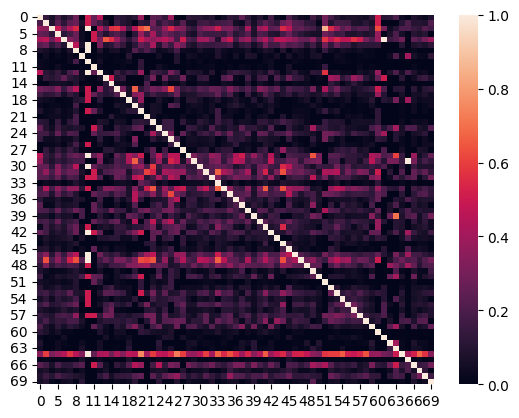

In [21]:
df_res = pd.DataFrame(dict_data)
sns.heatmap(df_res)

In [33]:
list_top10 = dict()
for idx, sim in dict_data.items():
    list_top10[idx] = sorted(sim.items(), key = lambda x: x[1], reverse=True)[1:11]

In [34]:
pd.DataFrame(list_top10).T

,0,1,2,3,4,5,6,7,8,9
0,"(12, 0.45714285714285713)","(28, 0.45714285714285713)","(6, 0.42857142857142855)","(4, 0.37142857142857144)","(29, 0.37142857142857144)","(64, 0.34285714285714286)","(16, 0.2857142857142857)","(5, 0.2571428571428571)","(23, 0.2571428571428571)","(30, 0.2571428571428571)"
3,"(47, 0.6346153846153846)","(64, 0.5961538461538461)","(6, 0.46153846153846156)","(34, 0.4423076923076923)","(31, 0.36538461538461536)","(4, 0.34615384615384615)","(46, 0.34615384615384615)","(48, 0.3076923076923077)","(7, 0.2692307692307692)","(16, 0.25)"
4,"(64, 0.3118811881188119)","(6, 0.27722772277227725)","(16, 0.23267326732673269)","(47, 0.19801980198019803)","(31, 0.18811881188118812)","(34, 0.18811881188118812)","(32, 0.1485148514851485)","(17, 0.12871287128712872)","(48, 0.12871287128712872)","(5, 0.12376237623762376)"
5,"(4, 0.49019607843137253)","(6, 0.45098039215686275)","(64, 0.37254901960784315)","(31, 0.35294117647058826)","(34, 0.35294117647058826)","(47, 0.35294117647058826)","(16, 0.3333333333333333)","(30, 0.3333333333333333)","(46, 0.27450980392156865)","(24, 0.2549019607843137)"
6,"(64, 0.4380952380952381)","(4, 0.26666666666666666)","(13, 0.24761904761904763)","(34, 0.22857142857142856)","(31, 0.20952380952380953)","(47, 0.20952380952380953)","(57, 0.2)","(48, 0.1619047619047619)","(30, 0.15714285714285714)","(55, 0.15714285714285714)"
...,...,...,...,...,...,...,...,...,...,...
65,"(65, 1.0)","(9, 0.4)","(18, 0.4)","(42, 0.4)","(46, 0.4)","(48, 0.4)","(64, 0.4)","(3, 0.2)","(4, 0.2)","(12, 0.2)"
66,"(64, 0.5212765957446809)","(28, 0.3829787234042553)","(29, 0.30851063829787234)","(50, 0.2765957446808511)","(31, 0.2553191489361702)","(48, 0.2553191489361702)","(6, 0.24468085106382978)","(32, 0.24468085106382978)","(39, 0.23404255319148937)","(47, 0.2127659574468085)"
67,"(64, 0.675)","(68, 0.3)","(58, 0.225)","(6, 0.2)","(35, 0.2)","(31, 0.175)","(46, 0.175)","(66, 0.15)","(4, 0.125)","(13, 0.125)"
68,"(64, 0.5670103092783505)","(6, 0.29896907216494845)","(31, 0.24742268041237114)","(58, 0.2268041237113402)","(4, 0.21649484536082475)","(35, 0.21649484536082475)","(47, 0.21649484536082475)","(48, 0.1958762886597938)","(29, 0.18556701030927836)","(34, 0.18556701030927836)"
